In [215]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import gc
from os.path import join as ospath
import tensorflow as tf
# from .utils import *
from tensorflow.keras.layers import Input,Flatten,Reshape,Dense, Lambda
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D,Cropping1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D,Cropping2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta,RMSprop,Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model



%matplotlib inline
import pylab as plt

## Using MNIST data for test

In [216]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_train.shape

(60000, 784)

## Function definition

In [217]:
import os

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder(x_test)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()



def dense_arch(x_in,arch,activation,last_layer_activation=None,activity_regularizer=None):
    
    assert x_in.get_shape().as_list()[1]==arch[0],'The size of the input layer is not compatible with the first layer!'
    
    assert len(arch)>1,'Number of layers has to be more than 1!'
    
    if len(arch)==2:
        if last_layer_activation is None:
            x = Dense(arch[1],
                      activation=activation,
                      activity_regularizer=activity_regularizer)(x_in)
            return x
        else:
            x = Dense(arch[1],
                      activation=last_layer_activation,
                      activity_regularizer=activity_regularizer)(x_in)
            return x
    
    x = Dense(arch[1],
              activation=activation,
              activity_regularizer=activity_regularizer)(x_in)
    for i in arch[2:-1]:
        x = Dense(i,
                  activation=activation,
                  activity_regularizer=activity_regularizer)(x)
    if last_layer_activation is None:
        x = Dense(arch[-1],
                  activation=activation,
                  activity_regularizer=activity_regularizer)(x)
    else:
        x = Dense(arch[-1],
                  activation=last_layer_activation,
                  activity_regularizer=activity_regularizer)(x)
    return x

def step_decay_schedule(initial_lr=1e-1, decay_factor=0.5, step_size=1, verbose=0):
    def schedule(epoch):
        lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return lr
    return LearningRateScheduler(schedule,verbose=verbose)

## Base AE class

In [218]:
class AutoEncoderBase(object):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 activation='relu',
                 activity_regularizer=None,
                 learning_rate=0.03,
                 batch_size=100,
                 debug_mode = False):

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.activity_regularizer = activity_regularizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_total = 0
        
        if debug_mode:
            self.input = Input(shape=(self.input_dim))
            self.encoded = self._encode(self.input)
            self.decoded = self._decode(self.encoded)
            self.encoder_index = 1
            self.prepare_models()
        
    def _encode(self, x_in):
        encoded = x_in
        return encoded
    
    def _decode(self, encoded):
        decoded = encoded
        return decoded
        
    def prepare_models(self, optimizer=None, loss=None):
        
        self.autoencoder = Model(self.input, self.decoded)
        
        self._encoder = Model(self.input, self.encoded)
        
        self.z_input = Input(shape=(self.latent_dim,))
        
        self.x_output = self.z_input
        for layer in self.autoencoder.layers[self.encoder_index:]:
            self.x_output = layer(self.x_output)
        
        self._decoder = Model(self.z_input, self.x_output)
        
        if optimizer is None:
            self.optimizer = Adadelta(self.learning_rate)
        else:
            self.optimizer = optimizer
            
        if loss is None:
            self.loss = 'binary_crossentropy'
        else:
            self.loss = loss
            
        self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

    def summary(self):
        self.autoencoder.summary()
                        
    def encoder(self, x):
        assert (x.shape[1]==self.input_dim),'Input dimension problem!'
        return self._encoder.predict(x)

    def decoder(self, z):
        assert (z.shape[1]==self.latent_dim),'Input dimension problem!'
        return self._decoder.predict(z)

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        
        callbacks = []
        if lr_sch:
            lr_sched = step_decay_schedule(verbose=verbose)
            callbacks += [lr_sched]
        if early_stop:
            earlystop = EarlyStopping(monitor = 'loss',
                                      min_delta = 0.01,
                                      patience = 3,
                                      verbose = verbose,
                                      restore_best_weights = True)
            callbacks += [earlystop]
        
        self.autoencoder.fit(x,
                             epochs=training_epochs,
                             batch_size=self.batch_size,
                             shuffle=True,
                             verbose=verbose,
                             callbacks=callbacks)

    def save(self, name='model.h5', path='./'):
        self.autoencoder.save_weights(ospath(path,name))

    def restore(self, name='model.h5', path='./'):
        self.autoencoder.load_weights(ospath(path,name))

    def get_batch(self, n_train,X):     
        pass
#         num, n_features = X.shape
#         num = X.shape[0]
#         indx = np.arange(num)
#         np.random.shuffle(indx)
#         indx = indx[:n_train]

#         x_batch = X[indx]
#         return x_batch

In [219]:
aeb = AutoEncoderBase(input_dim=784,latent_dim=784,debug_mode=True)

In [1]:
aeb.train(x_train,training_epochs=2)

(1, 784) (1, 784)


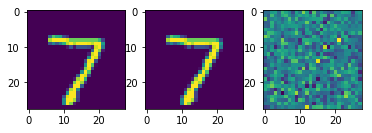

In [21]:
z = aeb.encoder(x_test[:1])
x = aeb.decoder(z)
xr = aeb.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

In [5]:
# class AutoEncoder(object):
#     def __init__(self, network_architecture=None, 
#                  activation='relu',
#                  last_layer_activation='sigmoid',
#                  learning_rate=0.001, batch_size=100):
#         self.activation = activation
#         self.epoch_total = 0
#         self.learning_rate = learning_rate
#         self.batch_size = batch_size
        
#         if network_architecture is None:
#             self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
#                                           [self.latent_dim,self.input_dim//2,self.input_dim] ]
#         else:
#             self.network_architecture = network_architecture
        
#         encoder_arch = network_architecture[0]
#         decoder_arch = network_architecture[1]
#         self.input_dim = encoder_arch[0]
#         self.latent_dim = encoder_arch[-1] 
        
#         assert len(encoder_arch)>1,'Encoder layers have to be more than 1!'
#         assert len(decoder_arch)>1,'Decoder layers have to be more than 1!'
#         assert encoder_arch[0]==decoder_arch[-1],"Input and output dimension have to be equal in encoder and decoder!"
#         assert encoder_arch[-1]==decoder_arch[0],"Latent layer dimension have to be equal in encoder and decoder!"

#         self.input = Input(shape=(encoder_arch[0],))
#         x = Dense(encoder_arch[1], activation=activation)(self.input)
#         for i in encoder_arch[2:]:
#             x = Dense(self.latent_dim, activation=activation)(x)
#         self.encoded = x
        
#         if len(decoder_arch)>2:
#             print('this')
#             x = Dense(decoder_arch[1], activation=activation)(self.encoded)
#             for i in decoder_arch[2:-1]:
#                 x = Dense(i, activation=last_layer_activation)(x)
#             self.decoded = Dense(decoder_arch[-1], activation=last_layer_activation)(x)
#         else:
#             print('that',decoder_arch)
#             self.decoded = Dense(decoder_arch[1], activation=last_layer_activation)(self.encoded)
            
#         self.autoencoder = Model(self.input, self.decoded)
        
#         self._encoder = Model(self.input, self.encoded)
        
#         self.encoded_input = Input(shape=(self.latent_dim,))
        
#         self.decoder_layer = self.autoencoder.layers[-1]
        
#         self._decoder = Model(self.encoded_input, self.decoder_layer(self.encoded_input))
        
#         self.optimizer = adadelta(self.learning_rate)
#         self.autoencoder.compile(optimizer=self.optimizer, loss='binary_crossentropy')

#     def __enter__(self):
#           return self

#     def __exit__(self, type, value, traceback):
#         pass

# #         gc.collect()


#     def summary(self):
#         self.autoencoder.summary()
                        
#     def encoder(self, x):
#         assert (x.ndim==2 and x.shape[1]==self.input_dim),'The shape have to be ?x{}'.format(self.input_dim)
#         return self._encoder.predict(x)

#     def decoder(self, z):
#         assert (z.ndim==2 and z.shape[1]==self.latent_dim),'The shape have to be ?x{}'.format(self.latent_dim)
#         return self._decoder.predict(z)

#     def train(self, x, training_epochs=10, verbose=True): 
        
#         self.autoencoder.fit(x, x,
#                 epochs=training_epochs,
#                 batch_size=self.batch_size,
#                 shuffle=True,
#                 verbose=verbose)

#     def save(self, name='model.h5', path='./'):
#         self.autoencoder.save_weights(ospath(path,name))

#     def restore(self, name='model.h5', path='./'):
#         self.autoencoder.load_weights(ospath(path,name))

#     def get_batch(self, n_train,X):     
#         pass
# #         num, n_features = X.shape
# #         num = X.shape[0]
# #         indx = np.arange(num)
# #         np.random.shuffle(indx)
# #         indx = indx[:n_train]

# #         x_batch = X[indx]
# #         return x_batch


# class AutoEncoder(object):
#     def __init__(self, network_architecture=None, 
#                  activation='relu',
#                  last_layer_activation='sigmoid',
#                  activity_regularizer=None,
#                  learning_rate=0.03, batch_size=100):
#         self.activation = activation
#         self.epoch_total = 0
#         self.learning_rate = learning_rate
#         self.batch_size = batch_size
        
#         if network_architecture is None:
#             self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
#                                           [self.latent_dim,self.input_dim//2,self.input_dim] ]
#         else:
#             self.network_architecture = network_architecture
        
#         encoder_arch = network_architecture[0]
#         decoder_arch = network_architecture[1]
#         self.input_dim = encoder_arch[0]
#         self.latent_dim = encoder_arch[-1] 
        
#         assert len(encoder_arch)>1,'Encoder layers have to be more than 1!'
#         assert len(decoder_arch)>1,'Decoder layers have to be more than 1!'
#         assert encoder_arch[0]==decoder_arch[-1],"Input and output dimension have to be equal in encoder and decoder!"
#         assert encoder_arch[-1]==decoder_arch[0],"Latent layer dimension have to be equal in encoder and decoder!"

#         self.input = Input(shape=(encoder_arch[0]))

#         self.encoded = dense_arch(self.input,
#                                   encoder_arch,
#                                   activation=activation,
#                                   activity_regularizer=activity_regularizer)
    
#         self.decoded = dense_arch(self.encoded,
#                                   decoder_arch,
#                                   activation=activation,
#                                   last_layer_activation=last_layer_activation,
#                                   activity_regularizer=activity_regularizer)
        
#         self.encoder_index = len(encoder_arch)
        
#     def prepare_models(self, optimizer=None, loss=None):
#         self.autoencoder = Model(self.input, self.decoded)
        
#         self._encoder = Model(self.input, self.encoded)
        
#         self.z_input = Input(shape=(self.latent_dim,))
        
#         self.x_output = self.z_input
#         for layer in self.autoencoder.layers[self.encoder_index:]:
#             self.x_output = layer(self.x_output)
        
#         self._decoder = Model(self.z_input, self.x_output)
        
#         if optimizer is None:
#             self.optimizer = Adadelta(self.learning_rate)
#         else:
#             self.optimizer = optimizer
            
#         if loss is None:
#             self.loss = 'binary_crossentropy'
#         else:
#             self.loss = loss
            
#         self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)

#     def summary(self):
#         self.autoencoder.summary()
                        
#     def encoder(self, x):
#         assert (x.ndim==2 and x.shape[1]==self.input_dim),'The shape have to be ?x{}'.format(self.input_dim)
#         return self._encoder.predict(x)

#     def decoder(self, z):
#         assert (z.ndim==2 and z.shape[1]==self.latent_dim),'The shape have to be ?x{}'.format(self.latent_dim)
#         return self._decoder.predict(z)

#     def train(self, x, 
#               training_epochs=10, 
#               lr_sch=True, 
#               early_stop=True,
#               verbose=True): 
        
#         callbacks = []
#         if lr_sch:
#             lr_sched = step_decay_schedule(verbose=verbose)
#             callbacks += [lr_sched]
#         if early_stop:
#             earlystop = EarlyStopping(monitor = 'loss',
#                                       min_delta = 0.01,
#                                       patience = 3,
#                                       verbose = verbose,
#                                       restore_best_weights = True)
#             callbacks += [earlystop]
        
#         self.autoencoder.fit(x, x,
#                 epochs=training_epochs,
#                 batch_size=self.batch_size,
#                 shuffle=True,
#                 verbose=verbose,
#                 callbacks=callbacks)

#     def save(self, name='model.h5', path='./'):
#         self.autoencoder.save_weights(ospath(path,name))

#     def restore(self, name='model.h5', path='./'):
#         self.autoencoder.load_weights(ospath(path,name))

#     def get_batch(self, n_train,X):     
#         pass
# #         num, n_features = X.shape
# #         num = X.shape[0]
# #         indx = np.arange(num)
# #         np.random.shuffle(indx)
# #         indx = indx[:n_train]

# #         x_batch = X[indx]
# #         return x_batch




# def schedule(epoch):
#     lr = 10e-3 * (0.75 ** np.floor(epoch))
#     print('show:',lr)
#     return lr


# class AutoEncoderBase(object):
#     def __init__(self,
#                  input_dim = None,
#                  latent_dim = None,
#                  activation='relu',
#                  activity_regularizer=None,
#                  learning_rate=0.03,
#                  batch_size=100):

#         self.input_dim = input_dim
#         self.latent_dim = latent_dim
#         self.activation = activation
#         self.activity_regularizer = activity_regularizer
#         self.learning_rate = learning_rate
#         self.batch_size = batch_size
#         self.epoch_total = 0
        
#         self.input = Input(shape=(self.input_dim))
#         self.encoded = self._encode(self.input)
#         self.decoded = self._decode(self.encoded)
        
#         self.encoder_index = 1
        
#         self.prepare_models()
        

class DenseAutoEncoder(AutoEncoderBase):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 network_architecture = None, 
                 activation = 'relu',
                 last_layer_activation = 'sigmoid',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        if network_architecture is None:
            self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
                                          [self.latent_dim,self.input_dim//2,self.input_dim] ]
        else:
            self.network_architecture = network_architecture
        
        self.encoder_arch = self.network_architecture[0]
        self.decoder_arch = self.network_architecture[1]
        self.input_dim = self.encoder_arch[0]
        self.latent_dim = self.encoder_arch[-1] 
        self.last_layer_activation = last_layer_activation
        
        assert len(self.encoder_arch)>1,'Encoder layers have to be more than 1!'
        assert len(self.decoder_arch)>1,'Decoder layers have to be more than 1!'
        assert self.encoder_arch[0]==self.decoder_arch[-1],\
                "Input and output dimension have to be equal in encoder and decoder!"
        assert self.encoder_arch[-1]==self.decoder_arch[0],\
                "Latent layer dimension have to be equal in encoder and decoder!"

        self.input = Input(shape=(self.input_dim))
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        
        self.encoder_index = len(self.encoder_arch)
        
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded = dense_arch(x_in,
                             arch = self.encoder_arch,
                             activation = self.activation,
                             activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):
        
        decoded = dense_arch(encoded,
                             arch = self.decoder_arch,
                             activation = self.activation,
                             last_layer_activation = self.last_layer_activation,
                             activity_regularizer = self.activity_regularizer)
        
        return decoded
        
        
        


### AE sample

In [7]:
dae = DenseAutoEncoder(network_architecture=[[784,100,32],[32,100,784]])
dae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 3s 58us/sample - loss: 0.5413

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2750

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2717

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 3s 48us/sample - loss: 0.2707

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2702
Epoch 00005: early stopping


(1, 784) (1, 32)


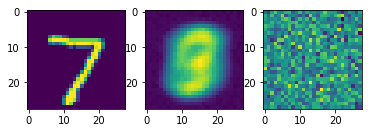

In [8]:
z = dae.encoder(x_test[:1])
x = dae.decoder(z)
xr = dae.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

#### check

In [9]:
x2 = dae.autoencoder.predict(x_test[:1])
np.sum((x2-x)**2)

0.0

### Sparse AE sample

In [37]:
sdae = DenseAutoEncoder([[784,20],[20,50,784]],activity_regularizer=l1(0.01))
sdae.train(x_train,training_epochs=10)

Train on 60000 samples
show: 0.1

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 3s 49us/sample - loss: 4.4849
show: 0.05

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 3s 44us/sample - loss: 2.0475
show: 0.025

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.9960
show: 0.0125

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.9570
show: 0.00625

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.9418
show: 0.003125

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [=====================

(1, 784) (1, 20)


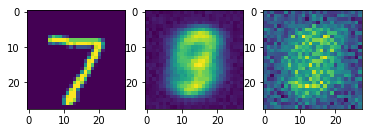

In [38]:
z = sdae.encoder(x_test[:1])
x = sdae.decoder(z)
xr = sdae.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

#### check

In [39]:
x2 = sdae.autoencoder.predict(x_test[:1])
np.sum((x2-x)**2)

0.0

### Model load/save test

In [41]:
print(dae._encoder.get_weights()[0].mean())
print(dae.autoencoder.get_weights()[0].mean())
print(dae._decoder.get_weights()[0].mean())
print(dae.autoencoder.get_weights()[2].mean())

0.0016177575
0.0016177575
0.00041230672
0.005689163


In [42]:
dae.save()

In [44]:
dae2 = DenseAutoEncoder([[784,100,32],[32,100,784]])

In [45]:
print(dae2._encoder.get_weights()[0].mean())
print(dae2.autoencoder.get_weights()[0].mean())
print(dae2._decoder.get_weights()[0].mean())
print(dae2.autoencoder.get_weights()[2].mean())

0.00014339476
0.00014339476
-0.0004192917
-0.0007160634


In [46]:
dae2.restore()

In [47]:
print(dae2._encoder.get_weights()[0].mean())
print(dae2.autoencoder.get_weights()[0].mean())
print(dae2._decoder.get_weights()[0].mean())
print(dae2.autoencoder.get_weights()[2].mean())

0.0016177575
0.0016177575
0.00041230672
0.005689163


In [48]:
print(dae._encoder.get_weights()[0].mean()-dae2._encoder.get_weights()[0].mean())
print(dae.autoencoder.get_weights()[0].mean()-dae2.autoencoder.get_weights()[0].mean())
print(dae._decoder.get_weights()[0].mean()-dae2._decoder.get_weights()[0].mean())
print(dae.autoencoder.get_weights()[2].mean()-dae2.autoencoder.get_weights()[2].mean())

0.0
0.0
0.0
0.0


### Architecture check

In [50]:
dae2 = DenseAutoEncoder([[784,100,40,10],[10,100,784]])
dae2.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4040      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_17 (Dense)             (None, 784)               79184     
Total params: 163,234
Trainable params: 163,234
Non-trainable params: 0
____________________________________________________

## Function definition

In [70]:
def encoder_cnn_1d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   pool_size,
                   activity_regularizer):
    
    y = Conv1D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if pool_size:
        y = MaxPooling1D(pool_size=pool_size,
                         strides=None,
                         padding='same')(y)
    return y

def decoder_cnn_1d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   upsample_size,
                   activity_regularizer):
    
    y = Conv1D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if upsample_size:
        y = UpSampling1D(size=upsample_size)(y)
    return y

def cond1d_arch_encoder(x_in,
                        latent_dim,
                        n_conv,
                        activation = 'relu',
                        filters = 4,
                        kernel_size = 5,
                        strides = 1,
                        pool_size = 2,
                        activity_regularizer=None):

    x = x_in

    for _ in range(n_conv-1):
        x = encoder_cnn_1d(x,
                          filters = filters,
                          kernel_size = kernel_size,
                          strides = strides,
                          activation = activation,
                          pool_size = pool_size,
                          activity_regularizer=activity_regularizer)

    x = encoder_cnn_1d(x,
                       filters = 1,
                       kernel_size = kernel_size,
                       strides = strides,
                       activation = activation,
                       pool_size=0,
                       activity_regularizer=activity_regularizer)

    x_shape = x.get_shape().as_list()

    x = Flatten()(x)

    encoded = Dense(latent_dim,
              activation=activation)(x)
    
    return encoded,x_shape

def cond1d_arch_decoder(encoded,
                        decoded_dim,
                        n_conv,
                        x_shape,
                        activation = 'relu',
                        filters = 4,
                        kernel_size = 5,
                        strides = 1,
                        upsample_size = 2,
                        activity_regularizer=None):

    x = Dense(x_shape[1]*x_shape[2],
              activation=activation)(encoded)

    x = Reshape(x_shape[1:])(x)

    for _ in range(n_conv-1):
        x = decoder_cnn_1d(x,
                           filters = filters,
                           kernel_size = kernel_size,
                           strides = strides,
                           activation = activation,
                           upsample_size = upsample_size,
                           activity_regularizer=activity_regularizer)

    decoded = decoder_cnn_1d(x,
                             filters = 1,
                             kernel_size = kernel_size,
                             strides = strides,
                             activation = activation,
                             upsample_size = 0,
                             activity_regularizer=activity_regularizer)

    delta_n = decoded.get_shape().as_list()[1] - decoded_dim

    d_crop = int(delta_n/2)
    if delta_n%2==0:
        decoded = Cropping1D((d_crop,d_crop))(decoded)
    else:
        decoded = Cropping1D((d_crop,d_crop+1))(decoded)
    
    return decoded

#### test

In [55]:
n_feature = 784
latent_dim = 10
n_conv = 5
activation='relu'
filters=4
kernel_size=5
strides=1
pool_size = 2
upsample_size=2


x_in = Input(shape=(n_feature, 1)) 

encoded,x_shape = cond1d_arch_encoder(x_in,
                                      latent_dim,
                                      n_conv,
                                      activation = activation,
                                      filters = filters,
                                      kernel_size = kernel_size,
                                      strides = strides,
                                      pool_size = pool_size)

decoded = cond1d_arch_decoder(encoded,
                              n_feature,
                              n_conv,
                              x_shape,
                              activation = activation,
                              filters = filters,
                              kernel_size = kernel_size,
                              strides = strides,
                              upsample_size = upsample_size)

autoencoder = Model(x_in, decoded)
autoencoder.summary()

Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 784, 1)]          0         
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 784, 4)            24        
_________________________________________________________________
max_pooling1d_119 (MaxPoolin (None, 392, 4)            0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 392, 4)            84        
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 196, 4)            0         
_________________________________________________________________
conv1d_208 (Conv1D)          (None, 196, 4)            84        
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 98, 4)             0  

In [85]:
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
input_dim = 3*3*3*5*7
latent_dim = 10
n_conv = 5
filters=4
kernel_size=5
strides=1
pool_size = 2
upsample_size=2


In [72]:
class ConvolutionalAutoEncoder1D(AutoEncoderBase):
    def __init__(self,
                 input_dim,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 kernel_size = 5,
                 strides = 1,
                 pool_size = 2,
                 upsample_size = 2,
                 activation = 'relu',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.n_conv = n_conv
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim, 1)) 
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded,self.x_shape = cond1d_arch_encoder(x_in,
                                                   self.latent_dim,
                                                   self.n_conv,
                                                   activation = self.activation,
                                                   filters = self.filters,
                                                   kernel_size = self.kernel_size,
                                                   strides = self.strides,
                                                   pool_size = self.pool_size,
                                                   activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):

        decoded = cond1d_arch_decoder(encoded,
                                      self.input_dim,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.filters,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        return super().encoder(x)

In [75]:
# self.z_input = Input(shape=(self.latent_dim,))
        
#         self.x_output = self.z_input
#         for layer in self.autoencoder.layers[self.encoder_index:]:
#             self.x_output = layer(self.x_output)

In [76]:
cae = ConvolutionalAutoEncoder1D(784,10,n_conv = 1)
# cae.summary()
cae.train(x_train,training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 10s 170us/sample - loss: 0.5551

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 12s 196us/sample - loss: 0.3255

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 10s 171us/sample - loss: 0.2851

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.2802

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2781

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.2771
Epoch 00006: early stop

In [77]:
z

(1, 784, 1) (1, 10)


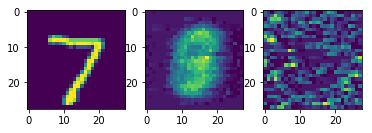

In [78]:
z = cae.encoder(x_test[:1])
x = cae.decoder(z)
xr = cae.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

#### check

In [80]:
x2 = cae.autoencoder.predict(x_test[:1][:,:,None])
np.sum((x2-x)**2)

0.0

## Function definition

In [181]:
def encoder_cnn_2d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   pool_size,
                   activity_regularizer):
    
    y = Conv2D(filters=filters, 
               kernel_size=kernel_size,
               strides=strides,
               activation=activation,
               padding='same',
               activity_regularizer=activity_regularizer)(x)
    
    if pool_size:
        y = MaxPooling2D(pool_size=pool_size,
                         strides=None,
                         padding='same')(y)
    return y

def decoder_cnn_2d(x,
                   filters,
                   kernel_size,
                   strides,
                   activation,
                   upsample_size,
                   activity_regularizer,
                   transpose = False):
    
    if transpose:
        y = Conv2DTranspose(filters = filters,
                            kernel_size = kernel_size,
                            strides = strides,
                            padding='same',
                            dilation_rate = (1, 1),
                            activation = activation,
                            activity_regularizer = activity_regularizer)(x)
    else:
        y = Conv2D(filters = filters, 
                   kernel_size = kernel_size,
                   strides = strides,
                   activation = activation,
                   padding = 'same',
                   activity_regularizer = activity_regularizer)(x)
    
    if upsample_size:
        y = UpSampling2D(size=upsample_size)(y)
        
        

        
    return y

def cond2d_arch_encoder(x_in,
                        latent_dim,
                        n_conv,
                        activation = 'relu',
                        filters = 4,
                        kernel_size = (5,5),
                        strides = (1,1),
                        pool_size = (2,2),
                        activity_regularizer = None):

    x = x_in

    for _ in range(n_conv-1):
        x = encoder_cnn_2d(x,
                          filters = filters,
                          kernel_size = kernel_size,
                          strides = strides,
                          activation = activation,
                          pool_size = pool_size,
                          activity_regularizer = activity_regularizer)

    x = encoder_cnn_2d(x,
                       filters = 1,
                       kernel_size = kernel_size,
                       strides = strides,
                       activation = activation,
                       pool_size = 0,
                       activity_regularizer = activity_regularizer)

    x_shape = x.get_shape().as_list()

    x = Flatten()(x)

    encoded = Dense(latent_dim,
              activation=activation)(x)
    
    return encoded,x_shape

def cond2d_arch_decoder(encoded,
                        decoded_dim_x,
                        decoded_dim_y,
                        n_conv,
                        x_shape,
                        activation = 'relu',
                        filters = 4,
                        kernel_size = (5,5),
                        strides = (1,1),
                        upsample_size = (2,2),
                        activity_regularizer = None,
                        transpose = False):

    x = Dense(x_shape[1]*x_shape[2]*x_shape[3],
              activation=activation)(encoded)

    x = Reshape(x_shape[1:])(x)

    for _ in range(n_conv-1):
        x = decoder_cnn_2d(x,
                           filters = filters,
                           kernel_size = kernel_size,
                           strides = strides,
                           activation = activation,
                           upsample_size = upsample_size,
                           activity_regularizer = activity_regularizer,
                           transpose = transpose)

    decoded = decoder_cnn_2d(x,
                             filters = 1,
                             kernel_size = kernel_size,
                             strides = (1,1),
                             activation = activation,
                             upsample_size = 0,
                             activity_regularizer = activity_regularizer,
                             transpose = transpose)
    
    d_shape = decoded.get_shape().as_list()
    delta_x = d_shape[1] - decoded_dim_x
    delta_y = d_shape[2] - decoded_dim_y

    d_crop_x = int(delta_x/2)
    d_crop_y = int(delta_y/2)
    
    if delta_x%2==0:
        d_crop_x = (d_crop_x,d_crop_x)
    else:
        d_crop_x = (d_crop_x,d_crop_x+1)
        
    if delta_y%2==0:
        d_crop_y = (d_crop_y,d_crop_y)
    else:
        d_crop_y = (d_crop_y,d_crop_y+1)
    
    decoded = Cropping2D(cropping=(d_crop_x,d_crop_y))(decoded)
    
    return decoded

#### test

In [184]:
nx,ny = 25,25
latent_dim = 10
n_conv = 3
activation='relu'
filters=4
kernel_size=5
strides=1
pool_size = 2
upsample_size=2


decoded_dim_x = nx
decoded_dim_y = ny

x_in = Input(shape=(nx, ny, 1)) 

encoded,x_shape = cond2d_arch_encoder(x_in,
                                      latent_dim,
                                      n_conv,
                                      activation = activation,
                                      filters = filters,
                                      kernel_size = kernel_size,
                                      strides = strides,
                                      pool_size = pool_size)

decoded = cond2d_arch_decoder(encoded,
                              decoded_dim_x,
                              decoded_dim_y,
                              n_conv,
                              x_shape,
                              activation = activation,
                              filters = filters,
                              kernel_size = kernel_size,
                              strides = (2,2),
                              upsample_size = 0,
                              transpose=1)

autoencoder = Model(x_in, decoded)
autoencoder.summary()

Model: "model_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 25, 25, 1)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 25, 25, 4)         104       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 13, 13, 4)         404       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 7, 7, 1)           101       
_________________________________________________________________
flatten_18 (Flatten)         (None, 49)                0 

In [12]:
class ConvolutionalAutoEncoder2D(AutoEncoderBase):
    def __init__(self,
                 input_dim_x,
                 input_dim_y,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 kernel_size = (5,5),
                 strides = (1,1),
                 pool_size = (2,2),
                 upsample_size = (2,2),
                 activation = 'relu',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = None,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.n_conv = n_conv
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim_x, self.input_dim_y, 1)) 
        self.encoded = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        encoded,self.x_shape = cond2d_arch_encoder(x_in,
                                                   self.latent_dim,
                                                   self.n_conv,
                                                   activation = self.activation,
                                                   filters = self.filters,
                                                   kernel_size = self.kernel_size,
                                                   strides = self.strides,
                                                   pool_size = self.pool_size,
                                                   activity_regularizer = self.activity_regularizer)

        return encoded
    
    def _decode(self, encoded):

        decoded = cond2d_arch_decoder(encoded,
                                      self.input_dim_x,
                                      self.input_dim_y,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.filters,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        assert (x.shape[1]==self.input_dim_x and x.shape[2]==self.input_dim_y),'Input dimension problem!'
        return self._encoder.predict(x)

In [13]:
cae2d = ConvolutionalAutoEncoder2D(28,28,10,n_conv = 3)
# cae2d.summary()
cae2d.train(x_train.reshape(-1,28,28,1),training_epochs=10)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/10
60000/60000 [==============================] - 40s 674us/sample - loss: 0.4420

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/10
60000/60000 [==============================] - 43s 709us/sample - loss: 0.2685

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/10
60000/60000 [==============================] - 43s 713us/sample - loss: 0.2657

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/10
60000/60000 [==============================] - 43s 713us/sample - loss: 0.2645

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/10
60000/60000 [==============================] - 43s 717us/sample - loss: 0.2640
Epoch 00005: early stopping


(1, 28, 28, 1) (1, 10)


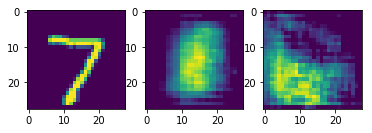

In [14]:
z = cae2d.encoder(x_test[:1].reshape(1,28,28,1))
x = cae2d.decoder(z)
xr = cae2d.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

In [17]:
x2 = cae2d.autoencoder.predict(x_test[:1].reshape(1,28,28,1))
np.sum((x2-x)**2)

0.0

24

# Variationals

In [170]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

class VariationalAutoEncoderBase(object):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 activation='relu',
                 activity_regularizer=None,
                 learning_rate=0.03,
                 batch_size=100,
                 debug_mode = False):

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.activation = activation
        self.activity_regularizer = activity_regularizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epoch_total = 0
        
        if debug_mode:
            self.input = Input(shape=(self.input_dim))
            self.encoded = self._encode(self.input)
            self.decoded = self._decode(self.encoded)
            self.encoder_index = 1
            self.prepare_models()
        
    def _encode(self, x_in):
        encoded = x_in
        return encoded
    
    def _decode(self, encoded):
        decoded = encoded
        return decoded
        
    def prepare_models(self, optimizer=None, loss=None):
        
        self.autoencoder = Model(self.input, self.decoded)
        
        self._encoder = Model(self.input, self.encoded)
        
        self.z_input = Input(shape=(self.latent_dim,))
        
        self.x_output = self.z_input
        for layer in self.autoencoder.layers[self.encoder_index:]:
            self.x_output = layer(self.x_output)
        
        self._decoder = Model(self.z_input, self.x_output)
        
        if optimizer is None:
            self.optimizer = Adadelta(self.learning_rate)
        else:
            self.optimizer = optimizer
            
        if loss is None:
            self.loss = mse
        else:
            self.loss = loss
            
        reconstruction_loss = self.input_dim*self.loss(K.flatten(self.input), K.flatten(self.decoded))
        kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
        kl_loss = -0.5*K.sum(kl_loss, axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.autoencoder.add_loss(vae_loss)
        self.autoencoder.compile(optimizer=self.optimizer)

    def summary(self):
        self.autoencoder.summary()
                        
    def encoder(self, x):
        assert (x.shape[1]==self.input_dim),'Input dimension problem!'
        return self._encoder.predict(x)

    def decoder(self, z):
        assert (z.shape[1]==self.latent_dim),'Input dimension problem!'
        return self._decoder.predict(z)
    
    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        
        callbacks = []
        if lr_sch:
            lr_sched = step_decay_schedule(verbose=verbose)
            callbacks += [lr_sched]
        if early_stop:
            earlystop = EarlyStopping(monitor = 'loss',
                                      min_delta = 0.01,
                                      patience = 3,
                                      verbose = verbose,
                                      restore_best_weights = True)
            callbacks += [earlystop]
        
        self.autoencoder.fit(x,
                             epochs=training_epochs,
                             batch_size=self.batch_size,
                             shuffle=True,
                             verbose=verbose,
                             callbacks=callbacks)

    def save(self, name='model.h5', path='./'):
        self.autoencoder.save_weights(ospath(path,name))

    def restore(self, name='model.h5', path='./'):
        self.autoencoder.load_weights(ospath(path,name))

    def get_batch(self, n_train,X):     
        pass
#         num, n_features = X.shape
#         num = X.shape[0]
#         indx = np.arange(num)
#         np.random.shuffle(indx)
#         indx = indx[:n_train]

#         x_batch = X[indx]
#         return x_batch

## DenseVariationalAutoEncoder

In [171]:
class DenseVariationalAutoEncoder(VariationalAutoEncoderBase):
    def __init__(self,
                 input_dim = None,
                 latent_dim = None,
                 network_architecture = None, 
                 activation = 'relu',
                 last_layer_activation = 'sigmoid',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        if network_architecture is None:
            self.network_architecture = [ [self.input_dim,self.input_dim//2,self.latent_dim],
                                          [self.latent_dim,self.input_dim//2,self.input_dim] ]
        else:
            self.network_architecture = network_architecture
        
        self.encoder_arch = self.network_architecture[0]
        self.decoder_arch = self.network_architecture[1]
        self.input_dim = self.encoder_arch[0]
        self.latent_dim = self.encoder_arch[-1] 
        self.last_layer_activation = last_layer_activation
        
        assert len(self.encoder_arch)>1,'Encoder layers have to be more than 1!'
        assert len(self.decoder_arch)>1,'Decoder layers have to be more than 1!'
        assert self.encoder_arch[0]==self.decoder_arch[-1],\
                "Input and output dimension have to be equal in encoder and decoder!"
        assert self.encoder_arch[-1]==self.decoder_arch[0],\
                "Latent layer dimension have to be equal in encoder and decoder!"

        self.input = Input(shape=(self.input_dim))
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        
#         self.encoder_index = len(self.encoder_arch)+2
        self.encoder_index = len(Model(self.input,self.encoded).layers)
        
        self.prepare_models()

    def _encode(self, x_in):

        x = dense_arch(x_in,
                       arch = self.encoder_arch[:-1],
                       activation = self.activation,
                       activity_regularizer = self.activity_regularizer)
        
        
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = dense_arch(encoded,
                             arch = self.decoder_arch,
                             activation = self.activation,
                             last_layer_activation = self.last_layer_activation,
                             activity_regularizer = self.activity_regularizer)

        return decoded
                


In [172]:
vae = DenseVariationalAutoEncoder(network_architecture=[[784,100,10,2],[2,10,100,784]])
vae.train(x_train.reshape(-1,784),training_epochs=3)

W1115 10:25:16.937352 140002308597568 training_utils.py:1348] Output dense_124 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_124.


Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/3
60000/60000 [==============================] - 3s 49us/sample - loss: 64.0219

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/3
60000/60000 [==============================] - 2s 41us/sample - loss: 51.2603

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/3
60000/60000 [==============================] - 3s 45us/sample - loss: 50.4508


(1, 784) (1, 2)


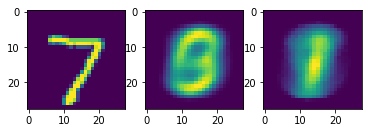

In [173]:
z = vae.encoder(x_test[:1])
x = vae.decoder(z)
xr = vae.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

In [174]:
x2 = vae.autoencoder.predict(x_test[:1])
np.sum((x2-x)**2)

3.926525

In [132]:
class ConvolutionalVariationalAutoEncoder1D(VariationalAutoEncoderBase):
    def __init__(self,
                 input_dim,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 kernel_size = 5,
                 strides = 1,
                 pool_size = 2,
                 upsample_size = 2,
                 activation = 'relu',
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = input_dim,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.n_conv = n_conv
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim, 1)) 
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        x,self.x_shape = cond1d_arch_encoder(x_in,
                                             2*self.latent_dim,
                                             self.n_conv,
                                             activation = self.activation,
                                             filters = self.filters,
                                             kernel_size = self.kernel_size,
                                             strides = self.strides,
                                             pool_size = self.pool_size,
                                             activity_regularizer = self.activity_regularizer)
        
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = cond1d_arch_decoder(encoded,
                                      self.input_dim,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.filters,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==2:
            x = np.expand_dims(x,-1)
        return super().encoder(x)

In [133]:
cvae = ConvolutionalVariationalAutoEncoder1D(784,10,n_conv = 3)
# cvae.summary()
cvae.train(x_train,training_epochs=5)

W1115 00:29:57.285937 140002308597568 training_utils.py:1348] Output cropping1d_7 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cropping1d_7.


Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/5
60000/60000 [==============================] - 31s 510us/sample - loss: 336.9127

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/5
60000/60000 [==============================] - 29s 481us/sample - loss: 257.4099

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/5
60000/60000 [==============================] - 28s 473us/sample - loss: 233.1988

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/5
60000/60000 [==============================] - 28s 467us/sample - loss: 230.8511

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/5
60000/60000 [==============================] - 28s 469us/sample - loss: 229.7438


(1, 784, 1) (1, 10)


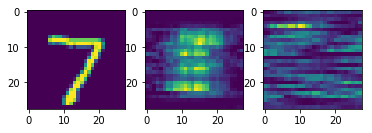

In [142]:
z = cvae.encoder(x_test[:1])
x = cvae.decoder(z)
xr = cvae.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

In [140]:
x2 = cvae.autoencoder.predict(x_test[:1][:,:,None])
np.sum((x2-x)**2)

5.556567

In [207]:
class ConvolutionalVariationalAutoEncoder2D(VariationalAutoEncoderBase):
    def __init__(self,
                 input_dim_x,
                 input_dim_y,
                 latent_dim,
                 n_conv = 2,
                 filters = 4,
                 kernel_size = (5,5),
                 strides = (1,1),
                 pool_size = (2,2),
                 upsample_size = (2,2),
                 activation = 'relu',
                 transpose = True,
                 activity_regularizer = None,
                 learning_rate = 0.03,
                 batch_size = 100):
        
        super().__init__(input_dim = None,
                         latent_dim = latent_dim,
                         activation = activation,
                         activity_regularizer = activity_regularizer,
                         learning_rate = learning_rate,
                         batch_size = batch_size)
        
        self.input_dim_x = input_dim_x
        self.input_dim_y = input_dim_y
        self.input_dim = input_dim_x*input_dim_y
        self.n_conv = n_conv
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.upsample_size = upsample_size
        self.transpose = transpose
        self.activity_regularizer = activity_regularizer
        
        self.input = Input(shape=(self.input_dim_x, self.input_dim_y, 1)) 
        self.encoded,self.z_mean, self.z_log_var = self._encode(self.input)
        self.decoded = self._decode(self.encoded)
        self.encoder_index = len(Model(self.input,self.encoded).layers)
#         self.encoder_index = 12
        self.prepare_models()
        
    def _encode(self, x_in):

        x,self.x_shape = cond2d_arch_encoder(x_in,
                                             2*self.latent_dim,
                                             self.n_conv,
                                             activation = self.activation,
                                             filters = self.filters,
                                             kernel_size = self.kernel_size,
                                             strides = self.strides,
                                             pool_size = self.pool_size,
                                             activity_regularizer = self.activity_regularizer)

        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        encoded = Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return encoded, z_mean, z_log_var
    
    def _decode(self, encoded):

        decoded = cond2d_arch_decoder(encoded,
                                      self.input_dim_x,
                                      self.input_dim_y,
                                      self.n_conv,
                                      self.x_shape,
                                      activation = self.activation,
                                      filters = self.filters,
                                      kernel_size = self.kernel_size,
                                      strides = self.strides,
                                      upsample_size = self.upsample_size,
                                      activity_regularizer = self.activity_regularizer,
                                      transpose = self.transpose)
        
        return decoded

    def train(self, x, 
              training_epochs=10, 
              lr_sch=True, 
              early_stop=True,
              verbose=True): 
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        super().train(x, 
                      training_epochs=training_epochs, 
                      lr_sch=lr_sch, 
                      early_stop=early_stop,
                      verbose=verbose)
        
    def encoder(self, x):
        if x.ndim==3:
            x = np.expand_dims(x,-1)
        assert (x.shape[1]==self.input_dim_x and x.shape[2]==self.input_dim_y),'Input dimension problem!'
        return self._encoder.predict(x)

In [208]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [209]:
cvae2d = ConvolutionalVariationalAutoEncoder2D(28,28,2,n_conv = 3, transpose=1)
cvae2d.summary()

W1115 11:05:51.444881 140002308597568 training_utils.py:1348] Output cropping2d_12 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cropping2d_12.


Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 28, 28, 4)    104         input_77[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 14, 14, 4)    0           conv2d_63[0][0]                  
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 14, 14, 4)    404         max_pooling2d_24[0][0]           
__________________________________________________________________________________________

In [210]:
cvae2d.train(x_train,training_epochs=30)

Train on 60000 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/30
60000/60000 [==============================] - 37s 618us/sample - loss: 60.3717

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
Epoch 2/30
60000/60000 [==============================] - 40s 672us/sample - loss: 53.7980

Epoch 00003: LearningRateScheduler reducing learning rate to 0.025.
Epoch 3/30
60000/60000 [==============================] - 35s 587us/sample - loss: 53.0540

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0125.
Epoch 4/30
60000/60000 [==============================] - 39s 643us/sample - loss: 52.6734

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00625.
Epoch 5/30
60000/60000 [==============================] - 37s 612us/sample - loss: 52.5093

Epoch 00006: LearningRateScheduler reducing learning rate to 0.003125.
Epoch 6/30
60000/60000 [==============================] - 36s 605us/sample - loss: 52.4068

Epoch 00007: 

(1, 28, 28, 1) (1, 2)


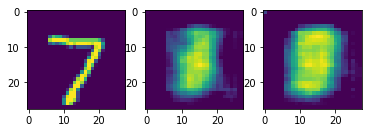

In [211]:
z = cvae2d.encoder(x_test[:1])
x = cvae2d.decoder(z)
xr = cvae2d.decoder(np.random.normal(0,1,z.shape))
print(x.shape,z.shape)

fig,(ax1,ax2,ax3) = plt.subplots(1,3)

ax1.imshow(x_test[:1].reshape(28,28))
ax2.imshow(x.reshape(28,28))
ax3.imshow(xr.reshape(28,28))

In [212]:
x2 = cvae2d.autoencoder.predict(x_test[:1])
np.sum((x2-x)**2)

0.81581193

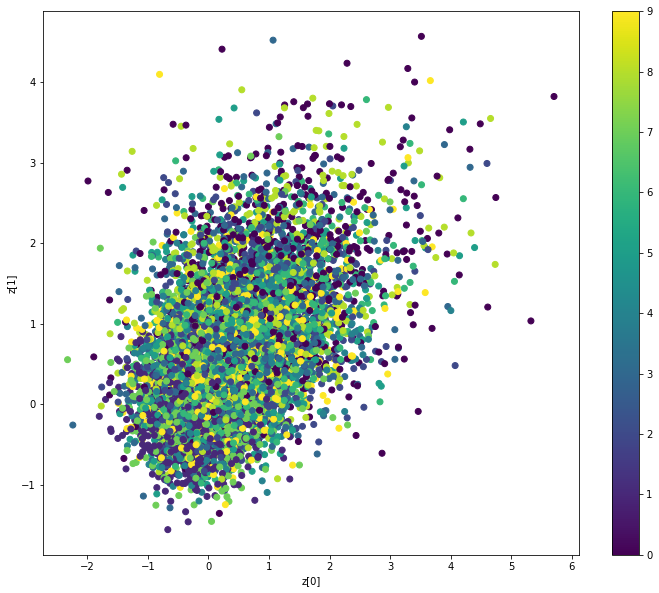

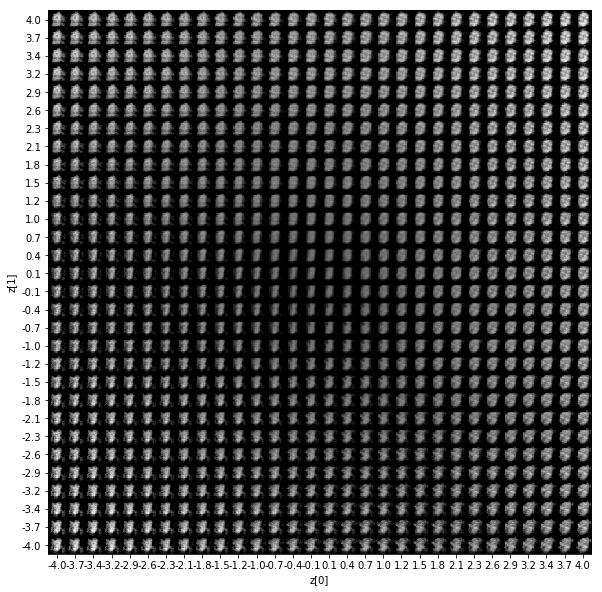

In [214]:
models = (cvae2d.encoder,cvae2d.decoder)
data = (x_test.reshape(-1,28,28,1), y_test)

plot_results(models,data,batch_size=128,model_name="test")